# Классификация посуды с помощью метода Bag-of-Visual-Words

Импортируем необходимые библиотеки

In [1]:
import numpy as np
import os
import os.path
import cv2
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.feature import hog
from skimage.exposure import rescale_intensity
import random
from tqdm import tqdm

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install tqdm
# !pip install ipywidgets

Сформируем датасет из директории с изображениями. Датасет содержит 2 столбца - категория объекта и путь к файлу. Общее количество изображений - 143.

In [3]:
dir = './Dataset_origin'

In [4]:
# создадим датафрем с нашими данными.
def create_df(directory):
    name = []
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            name.append([dirname.split('/')[-1], os.path.join(dirname, filename)])
    
    
    return pd.DataFrame(columns = ['category', 'way'], data = name)

df = create_df('./Dataset_origin')
df.shape

(143, 2)

In [5]:
# заменим категриальные признаки на числовые
slovar = {}
my_list = df['category'].unique()
for counter, value in enumerate(my_list):
    slovar[value] = counter

df['category'] = df['category'].map(slovar)

In [6]:
df.head()

,category,way
0,0,./Dataset_origin/fork/IMG_20211219_193440.jpg
1,0,./Dataset_origin/fork/IMG_20211219_193329.jpg
2,0,./Dataset_origin/fork/fork.jpg
3,0,./Dataset_origin/fork/IMG_20211219_193508.jpg
4,0,./Dataset_origin/fork/IMG_20211120_173901.jpg


Посмотрим на доли классов в нашей выборке. Доли примерно равные, максимальная доля класса - 18%. Если модель будет всем объектам предсказывать категорию 0, то accuracy такой модели будет около 0,18.

In [7]:
np.round(df.groupby("category")["way"].count() / df.shape[0] * 100, 2)

category
0    18.18
1    16.78
2    16.78
3    16.08
4    16.78
5    15.38
Name: way, dtype: float64

In [8]:
slovar

{'fork': 0, 'plate': 1, 'knife': 2, 'cup': 3, 'glass': 4, 'spoon': 5}

Разделим выборку на train и val в пропорции 80:20. Будем использовать стратификацию, чтобы доли классов в обучающей и валидационной выборке совпадали с исходной выборкой.

Так мы получим 114 изображений в тестовой и 29 в валидационной выборке.

In [9]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.2, stratify = df["category"], random_state=10)

In [10]:
df_train.shape, df_val.shape

((114, 2), (29, 2))

## Предобработка изображений

Для каждого изображения применим нормировку яркости, изменим размер до 128х128 и применим детектор границ Кенни. Сглаживание Гаусса применяется внутри детектора Кенни.

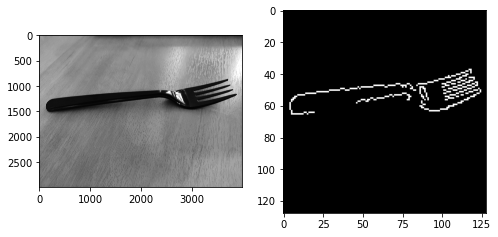

In [11]:
def first_prepare(img):
     # нормализуем интенсивности от 0 до 255
    img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    
    # уменьшим размер
    img = cv2.resize(img, (128, 128))
    
    # найдем границы на изображении
    img = cv2.Canny(np.uint8(img), 200, 450)
#     img = cv2.Canny(np.uint8(img), 100, 200)
    
    return img

# пример работы функции предобработки
img = cv2.imread(df_train.iloc[47, 1], cv2.IMREAD_GRAYSCALE)
img_prepared = first_prepare(img)

fig, axx = plt.subplots(1, 2, figsize= (8,4))
axx[0].imshow(img, cmap="gray")
axx[1].imshow(img_prepared, cmap="gray")

## Аугментация изображений

Аугментация будет включать в себя:
- случайный поворот на угол от -20 до +20 градусов
- случайное отображение относительно вертикальной оси

Аугментации будем делать "на лету", чтобы не хранить на диске большое количество фотографий и чтобы аугментированные фотографии попадали в обучающую или валидационную выборку вместе с исходным изображением. Это даст уверенность, что метрики качества модели не будут завышены из-за попадания почти одинаковых изображений в обучающую и валидационную выборки.

In [17]:
def rot(image, angle=5, scale=1.0):
    # поворот
    return rotate(image, angle, resize=False, mode="edge") * 255

def flip(image, vflip=False, hflip=False):
    # перевернуть изображение
    if hflip or vflip:
        if hflip and vflip:
            c = -1
        else:
            c = 0 if vflip else 1
        image = cv2.flip(image, flipCode=c)
    return image 

# не используется из-за ошибок в детекторе canny после такой обработки
def color(image_name):
    # поменяем матрицу hsv
    image = cv2.imread(image_name, cv2.COLOR_BGR2HSV) 
    h,s,v = cv2.split(image)
    new_image = cv2.merge((h+10,s-20,v+15))
    image = cv2.cvtColor(new_image, cv2.COLOR_HSV2RGB)
    return image

In [13]:
def augmentation(image_name, n_aug):
    
    # Augmentation для наших данных
    # image_name - путь к файлу
    # n_aug -  номер текущей аугментации, чтобы различать изображения в обучающем датасете

    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)  
    file_name = image_name[len("./Dataset_origin"):-4]

    # случайный flip
    if (random.random() > 0.5):  
        image = flip(image, vflip=False, hflip=True)
    # случайный поворот
    angle = random.randint(-20, 20)
    image = rot(image, angle=angle)
    #img_gaussian = add_GaussianNoise(img)
    
    image = rescale_intensity(image, out_range=(0, 255))

    return image

## Составление словаря слов
Каждую картинку (исходный размер 128х128) разделим на ячейки 16х16 со смещением 8 пикселей. Итого получим 225 ячеек. 

Для каждой из них вычислим гистограмму направленных градиентов HOG по 9 направлением. Итого каждый объект (слово) будет представлять из себя вектор длины 9, из каждой картинки получим 225 слов.

Все слова из всех картинок разделим на кластеры с помощью алгоритмя K-means (количество кластеров попробуем разное, для начала - 30 штук).
Тогда наш словарь будет состоять из 30 слов.

In [14]:
def get_frames(image, image_name):
    # получает 225 векторов длины 9 из каждой картинки
    # и возвращает dataframe с этими векторами
    
    # исходный размер изображения 128*128
    win_size = (128, 128)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (16, 16)
    n_bins = 9

    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, n_bins)

    winStride = (8, 8) 
    padding = (0, 0) 
    hist = hog.compute(image, winStride, padding) 

    # количество ячеек 15 * 15, по 9 бинов в каждом = 2025
    # сделаем resize в матрицу 225*9, чтобы каждая ячейка (слово) описывалась отдельно
    
    data = np.reshape(hist, (225, 9))
    df = pd.DataFrame(data)
    df["row"] = df.index % 15
    df["col"] = df.index // 15 
    df["name"] = image_name
    
    return df[["name", "row", "col", 0, 1, 2, 3, 4, 5, 6, 7, 8]]

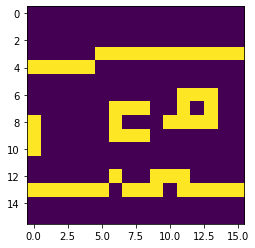

In [15]:
def frame_image(name, row, col):
    # по имени файла, номеру строки (от 0 до 14),
    # номеру колонки (от 0 до 14)
    # возвращает фрагмент изображения 16х16
    
    image = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
    image = first_prepare(image)
    
    frame = image[row * 8 : (row + 2) * 8, col * 8 : (col + 2) * 8]
    return frame

# пример работы функции
plt.imshow(frame_image("./Dataset_origin/fork/IMG_20211119_084920.jpg", 6, 6))

In [16]:
# обучим K-means на наших данных
from sklearn.cluster import KMeans


n_augmentations = 10


# сформируем список файлов
file_list = df_train["way"].to_list()

# сформируем dataframe со словами, из него для обучения возьмем только часть колонок 
# название файла и месторасположение фрагмента не берем

train_frames_data = pd.DataFrame(columns=["name", "row", "col", 0, 1, 2, 3, 4, 5, 6, 7, 8])

for file in tqdm(file_list):
    for i_augment in range(n_augmentations):
        img = augmentation(file, i_augment) if i_augment > 0 else cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        aug_name = file + "_" + str(i_augment)
        img = first_prepare(img)

        train_frames_data = pd.concat([train_frames_data, get_frames(img, aug_name)], axis=0)

train_frames_data.reset_index(drop=True, inplace=True)        
X_hog_train = train_frames_data[[0, 1, 2, 3, 4, 5, 6, 7, 8]]




100%|█████████████████████████████████████████| 114/114 [21:08<00:00, 11.12s/it]


Размер датасета, состоящего из фрагментов изображений, а точнее, из hog этих фрагментов (векторов длины 9):

In [18]:
X_hog_train.shape

(256500, 9)

In [19]:
n_clusters = 30
cls = KMeans(n_clusters=n_clusters)

# обучим алгоритм кластеризации
cls.fit(X_hog_train)

KMeans(n_clusters=30)

Посмотрим на получившиеся кластеры. Для этого в dataframe с информацией о фрагментах всех изображений добавим значение кластера.

И посмотрим на объемы кластеров.

In [20]:
train_frames_data["cluster"] = cls.predict(X_hog_train)

train_frames_data["cluster"].value_counts()

0     149142
1       8997
2       8628
19      8069
15      5894
5       5869
23      5779
26      5260
13      4930
28      4771
9       4714
10      4695
3       4448
18      3420
4       3304
8       3246
6       2919
29      2891
25      2784
7       2496
16      2293
24      2128
14      1363
21      1348
11      1342
12      1338
22      1283
17      1223
20      1218
27       708
Name: cluster, dtype: int64

Видно, что есть один наиболее многочисленный кластер (более половины фрагментов - пустые) и 29 менее многочисленных.

Для визуальной оценки кластеров возьмем несколько фрагментов самого многочисленного кластера:

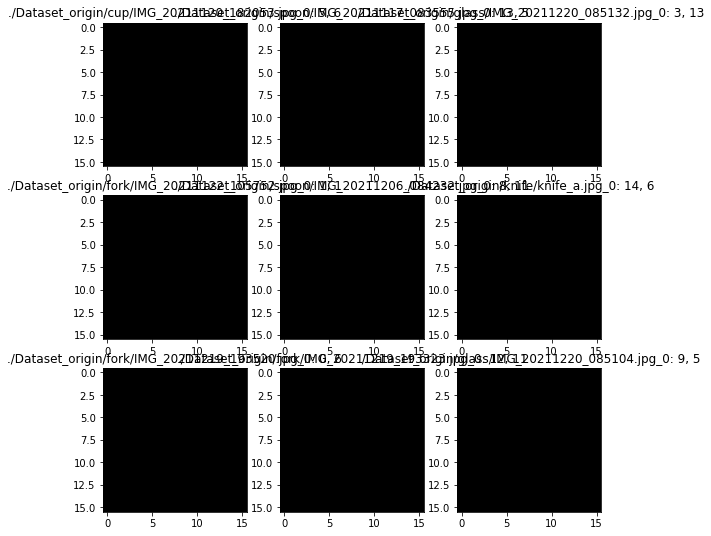

In [21]:
cluster = 0

origin_mask = train_frames_data["name"].apply(lambda x: ".jpg_0" in x)
not_aug_frames = train_frames_data[origin_mask]

sample = not_aug_frames[not_aug_frames["cluster"] == cluster].sample(n=9)
sample.reset_index(drop=True, inplace=True)

fig = plt.figure(figsize=(9, 9))

for i in range(9):
    name = sample.loc[i, "name"]
    row = sample.loc[i, "row"]
    col = sample.loc[i, "col"]

    plt.subplot(3, 3, i + 1)
    plt.imshow(frame_image(name[:-2], row, col), cmap='gray')
    plt.title(f"{name}: {row}, {col}")


И какого-нибудь кластера среднего размера

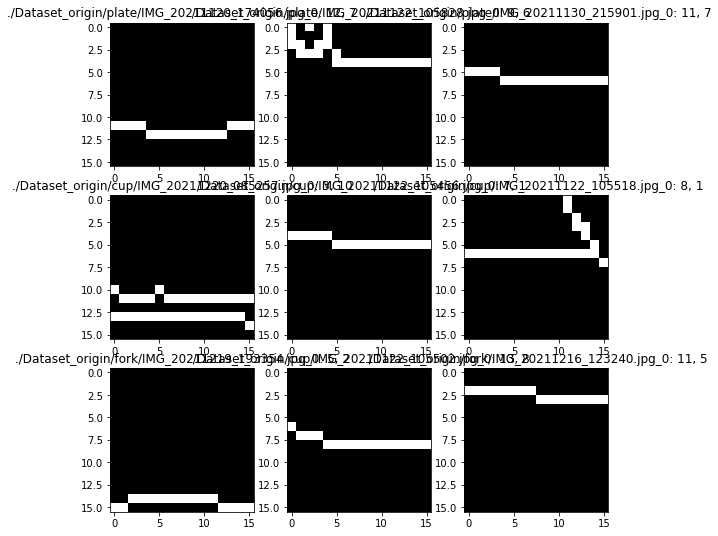

In [22]:
cluster = 11

sample = not_aug_frames[not_aug_frames["cluster"] == cluster].sample(n=9)
sample.reset_index(drop=True, inplace=True)

fig = plt.figure(figsize=(9, 9))

for i in range(9):
    name = sample.loc[i, "name"]
    row = sample.loc[i, "row"]
    col = sample.loc[i, "col"]
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(frame_image(name[:-2], row, col), cmap='gray')
    plt.title(f"{name}: {row}, {col}")

### Построение feature vector для изображений

Теперь мы можем посмотреть на все 225 фрагментов изображения и определить, к какому из кластеров они относятся и записать частоту этого слова в соответствующую ячейку.

Так как наш словарь включает в себя 30 слов, то каждое изображение можно описать вектором длины 30, где на i-м месте стоит частота i-го слова.

Информация о номере кластера для каждого фрагмента каждого изображения у нас уже записана в dataframe, нам нужно только группировать ее по названию файла.

In [22]:
# попробуем описывать изображения не частотой слов, а TF-IDF

# from sklearn.feature_extraction.text import TfidfVectorizer

# def create_tfidf_features(data):
#     data["cluster"] = data["cluster"].astype(np.str)
#     sequences = data.groupby("name")["cluster"].agg(" ".join)
#     vectorizer = TfidfVectorizer()
#     tfidf_matrix = vectorizer.fit_transform(sequences)
#     data_res = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix)
#     data_res.index = sequences.index
#     return data_res

# features_train = create_tfidf_features(train_frames_data)

In [23]:
def create_features(data, vocab_volume):
    df_counts = (data[["name", "cluster", "row"]]
                 .groupby(["name", "cluster"], as_index=False)
                 .agg("count")
    )
    df_counts = df_counts.rename(columns={"row": "count"})
    # проверка на присутствие всех кластеров
    names_list = df_counts["name"].unique()
    for name in names_list:
        values_list = df_counts[df_counts["name"] == name]["cluster"].to_list() 
        for i in range(vocab_volume):          
            if i not in values_list:
                df_counts = df_counts.append({"name": name, "cluster": i, "count": 0}, ignore_index=True)
    
    
    df_counts_wide = df_counts.pivot_table(index=["name"], 
                                           columns=["cluster"], 
                                           values=["count"], 
                                           fill_value=0)
    df_counts_wide.columns = df_counts_wide.columns.get_level_values(1)
    
    
    return df_counts_wide


features_train = create_features(train_frames_data, n_clusters)
features_train.head()

cluster,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
name,,,,,,,,,,,,,,,,,,,,,
./Dataset_origin/cup/IMG_20211117_085845.jpg_0,122,6,5,14,5,11,4,5,2,2,...,3,0,0,3,6,5,0,1,3,2
./Dataset_origin/cup/IMG_20211117_085845.jpg_1,108,5,9,8,5,9,3,0,3,6,...,2,1,1,8,5,6,2,0,2,2
./Dataset_origin/cup/IMG_20211117_085845.jpg_2,109,8,7,6,2,13,0,5,2,4,...,4,3,1,4,4,1,8,1,2,5
./Dataset_origin/cup/IMG_20211117_085845.jpg_3,102,2,18,0,2,4,0,11,2,0,...,3,4,2,8,0,0,4,0,1,3
./Dataset_origin/cup/IMG_20211117_085845.jpg_4,103,7,19,11,2,5,1,4,3,8,...,0,0,0,7,3,1,10,0,3,7


Теперь нужно склеить полученное описание с целевой переменной.

In [24]:
features_train["origin_name"] = features_train.index
features_train["origin_name"] = features_train["origin_name"].apply(lambda x: x[:x.rfind("_")])
features_train.reset_index(inplace=True)
data_train = pd.merge(features_train, df_train, 
                      left_on="origin_name", right_on="way")
data_train.set_index("name", inplace=True)
data_train.drop(["origin_name", "way"], axis=1, inplace=True)

In [25]:
y_train = data_train.pop("category")
X_train = data_train

In [26]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
name,,,,,,,,,,,,,,,,,,,,,
./Dataset_origin/cup/IMG_20211117_085845.jpg_0,122,6,5,14,5,11,4,5,2,2,...,3,0,0,3,6,5,0,1,3,2
./Dataset_origin/cup/IMG_20211117_085845.jpg_1,108,5,9,8,5,9,3,0,3,6,...,2,1,1,8,5,6,2,0,2,2
./Dataset_origin/cup/IMG_20211117_085845.jpg_2,109,8,7,6,2,13,0,5,2,4,...,4,3,1,4,4,1,8,1,2,5
./Dataset_origin/cup/IMG_20211117_085845.jpg_3,102,2,18,0,2,4,0,11,2,0,...,3,4,2,8,0,0,4,0,1,3
./Dataset_origin/cup/IMG_20211117_085845.jpg_4,103,7,19,11,2,5,1,4,3,8,...,0,0,0,7,3,1,10,0,3,7


In [27]:
X_train.shape

(1140, 30)

In [28]:
y_train.head()

name
./Dataset_origin/cup/IMG_20211117_085845.jpg_0    3
./Dataset_origin/cup/IMG_20211117_085845.jpg_1    3
./Dataset_origin/cup/IMG_20211117_085845.jpg_2    3
./Dataset_origin/cup/IMG_20211117_085845.jpg_3    3
./Dataset_origin/cup/IMG_20211117_085845.jpg_4    3
Name: category, dtype: int64

In [29]:
# сформируем X_val и y_val, объединим проделанную процедуру в функцию

def create_xy_data(df, clf_model):
    # df - dataframe именами файлов и категориями
    # clf_model - модель кластеризации, обученная ранее
    
    file_list = df["way"].to_list()
    
    df_frames = pd.DataFrame(columns=["name", "row", "col", 0, 1, 2, 3, 4, 5, 6, 7, 8])

    for file in tqdm(file_list):
        for i_augment in range(n_augmentations):
            img = augmentation(file, i_augment) if i_augment > 0 else cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            aug_name = file + "_" + str(i_augment)
            img = first_prepare(img)

            df_frames = pd.concat([df_frames, get_frames(img, aug_name)], axis=0)

    df_frames.reset_index(drop=True, inplace=True)        

    df_hog = df_frames[[0, 1, 2, 3, 4, 5, 6, 7, 8]]
    
    df_frames["cluster"] = clf_model.predict(df_hog)
    features = create_features(df_frames, clf_model.get_params()["n_clusters"])
#     features = create_tfidf_features(df_frames)
    features["origin_name"] = features.index
    features["origin_name"] = features["origin_name"].apply(lambda x: x[:x.rfind("_")])
    features.reset_index(inplace=True)
    data = pd.merge(features, df, 
                    left_on="origin_name", right_on="way")
    data.set_index("name", inplace=True)
    data.drop(["origin_name", "way"], axis=1, inplace=True)
    
    y = data.pop("category")
    X = data 
    return X, y

X_val, y_val = create_xy_data(df_val, cls)


100%|███████████████████████████████████████████| 29/29 [05:27<00:00, 11.28s/it]


In [30]:
X_val.shape

(290, 30)

In [37]:
# обучим SVM и XGBoost на наших данных

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_svc = Pipeline([
    ('scaler_', StandardScaler()),
    ('model_', SVC(C=1.5))])


pipe_svc.fit(X_train, y_train)

pipe_xgbst = Pipeline([
    ('scaler_', StandardScaler()),
    ('model_', XGBClassifier(n_estimators=10, max_depth=4, verbosity=0))])


pipe_svc.fit(X_train, y_train)
pipe_xgbst.fit(X_train, y_train)


Pipeline(steps=[('scaler_', StandardScaler()),
                ('model_',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=4, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=10,
                               n_jobs=12, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsample=1,
                               tree_method='exact', validate_parameters

In [38]:
from sklearn.metrics import accuracy_score
print("accuracy SVC train: ", accuracy_score(pipe_svc.predict(X_train), y_train), ", val: ", accuracy_score(pipe_svc.predict(X_val), y_val), 
      "\naccuracy XGBoost train: ", accuracy_score(pipe_xgbst.predict(X_train), y_train), ", val: ",accuracy_score(pipe_xgbst.predict(X_val), y_val))

accuracy SVC train:  0.8614035087719298 , val:  0.5379310344827586 
accuracy XGBoost train:  0.8587719298245614 , val:  0.5137931034482759


Для сравнения построим случайный классификатор, который любому объекту будет предсказывать класс случайно, с одинаковой вероятностью.

In [39]:
from sklearn.dummy import DummyClassifier

d_cls = DummyClassifier(strategy='uniform')
d_cls.fit(X_train, y_train)

accuracy_score(y_val, d_cls.predict(X_val))

0.16206896551724137

### Подбор гиперпараметров

Попробуем подобрать размер словаря и параметры, чтобы улучшить качество модели.


In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_hp = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC())])


clfs = []
for n in range(20, 70, 10):
    clf = KMeans(n_clusters=n)
    clf.fit(X_hog_train)
    clfs.append(clf)

for clf in clfs:
    X_train, y_train = create_xy_data(df_train, clf)
    
    gs = GridSearchCV(pipe_hp,
                     param_grid={"model__C": [0.5 * x for x in range(1, 5)]})
    gs.fit(X_train, y_train)
    
    X_val, y_val = create_xy_data(df_val, clf)
    print(clf, accuracy_score(y_val, gs.predict(X_val)), gs.best_params_)

100%|███████████████████████████████████████████| 29/29 [02:11<00:00,  4.54s/it]


KMeans(n_clusters=20) 0.5 {'model__C': 2.0}


100%|███████████████████████████████████████████| 29/29 [02:11<00:00,  4.53s/it]


KMeans(n_clusters=30) 0.4862068965517241 {'model__C': 1.5}


100%|███████████████████████████████████████████| 29/29 [02:14<00:00,  4.64s/it]


KMeans(n_clusters=40) 0.5620689655172414 {'model__C': 1.5}


100%|███████████████████████████████████████████| 29/29 [04:36<00:00,  9.54s/it]


KMeans(n_clusters=50) 0.5241379310344828 {'model__C': 2.0}


100%|███████████████████████████████████████████| 29/29 [02:15<00:00,  4.66s/it]


KMeans(n_clusters=60) 0.4862068965517241 {'model__C': 1.5}


Выберем размер словаря - 40 слов и снова посмотрим на результат на тестовых данных

In [41]:
cls = KMeans(n_clusters=40)

file_list_train = df_train["way"].to_list()
train_frames_data = pd.DataFrame(columns=["name", "row", "col", 0, 1, 2, 3, 4, 5, 6, 7, 8])

for file in tqdm(file_list):
    for i_augment in range(n_augmentations):
        img = augmentation(file, i_augment) if i_augment > 0 else cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        aug_name = file + "_" + str(i_augment)
        img = first_prepare(img)

        train_frames_data = pd.concat([train_frames_data, get_frames(img, aug_name)], axis=0)

train_frames_data.reset_index(drop=True, inplace=True)    
X_hog_train = train_frames_data[[0, 1, 2, 3, 4, 5, 6, 7, 8]]

cls.fit(X_hog_train)

X_train, y_train = create_xy_data(df_train, cls)

X_val, y_val = create_xy_data(df_val, cls)
    

100%|███████████████████████████████████████████| 29/29 [02:12<00:00,  4.55s/it]


In [42]:
pipe_1 = Pipeline([
    ('scaler_', StandardScaler()),
    ('model_', SVC(C=1.5))]).fit(X_train, y_train)
accuracy_score(y_val, pipe_1.predict(X_val))

0.5551724137931034

## KNN модель

In [35]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=20, weights='distance')
knn.fit(X_train, y_train)
accuracy_score(knn.predict(X_val), y_val)


0.5137931034482759

## Посмотрим, на каких объектах модель ошибается чаще.

In [43]:
predict = pipe_1.predict(X_val)
# predict = knn.predict(X_val)
val_result = pd.DataFrame(data = np.array([y_val, predict]).T,
                           columns = ["y_true", "y_predict"],
                         index = X_val.index)

val_result["match"] = (val_result["y_true"] == val_result["y_predict"])
matched = val_result.groupby("y_true")["match"].mean()
matched.index = list(slovar.keys())
matched

fork     0.68
plate    0.74
knife    0.70
cup      0.54
glass    0.20
spoon    0.45
Name: match, dtype: float64

<AxesSubplot:>

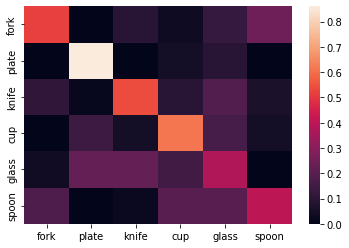

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(predict, y_val, normalize="true"), 
            xticklabels=list(slovar.keys()), 
            yticklabels=list(slovar.keys()))

Лучше всего дело обстоит с тарелками, ножами и вилками. Хуже всего - со стаканами.

In [45]:
slovar

{'fork': 0, 'plate': 1, 'knife': 2, 'cup': 3, 'glass': 4, 'spoon': 5}

Этот стакан модель классифицировала как ложку. Проблема в том, что при выбранных параметрах детектора Кенни, стаканы теряют большую часть своих границ из-за прозрачности. Если сделать параметры подходящими для стаканов - в остальных категориях снижается качество предобработки.

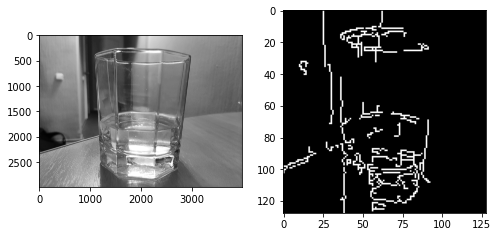

In [48]:
img = cv2.imread("./Dataset_origin/glass/IMG_20211118_154923.jpg", cv2.IMREAD_GRAYSCALE)

img_prepared = first_prepare(img)

fig, axx = plt.subplots(1, 2, figsize= (8,4))
axx[0].imshow(img, cmap="gray")
axx[1].imshow(img_prepared, cmap="gray")